In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_ind, norm, f_oneway, tukey_hsd
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.metrics import r2_score

In [2]:
mean_data = pd.read_parquet('averaged_data.parquet').set_index('[run number]').sort_index()

In [3]:
mean_data.columns = mean_data.columns.str.replace('-', '_')

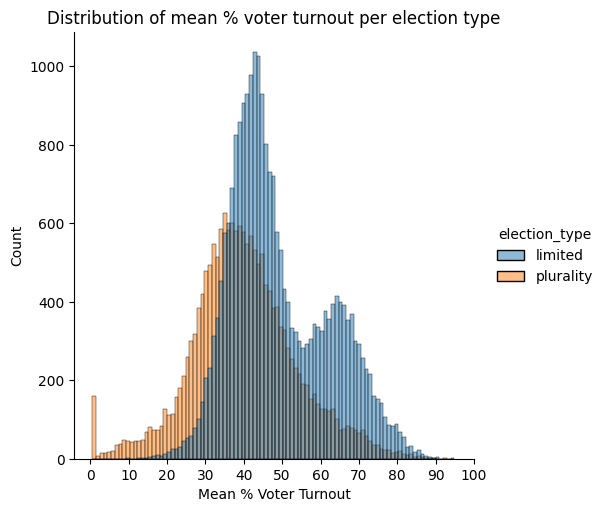

In [4]:
sns.displot(data=mean_data, x='voter_turnout', hue='election_type')
plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Mean % Voter Turnout')
plt.title('Distribution of mean % voter turnout per election type')
plt.savefig('plots/mean_voter_turnout.pdf', bbox_inches='tight')
plt.show()

Fit a GMM to the limited mean % voter turnout in order to estimate the $\langle \mu, \sigma \rangle$ of the 2 normal distributions.

In [5]:
gmm = GaussianMixture(n_components=2, random_state=0)
lim_data = mean_data.query('election_type == "limited"')['voter_turnout'].values.reshape(-1, 1)
gmm.fit(lim_data)
preds = gmm.predict(lim_data)

In [6]:
gmm.converged_

True

In [7]:
gmm.means_

array([[41.80481564],
       [64.99353604]])

In [8]:
np.sqrt(gmm.covariances_)

array([[[6.77670147]],

       [[7.88536053]]])

In [9]:
gmm.weights_

array([0.68154123, 0.31845877])

In [10]:
mean_data['group'] = 2
mean_data.loc[mean_data.query('election_type == "limited"').index, 'group'] = preds

In [11]:
mean_data['group'].value_counts()

2    18000
0    16565
1     7435
Name: group, dtype: int64

Check mean and standard deviation of the groups to see which parameters vary between the groups.

In [12]:
mean_data.drop('election_type', axis=1).groupby('group').agg(['mean', 'std'])

winning_candidates           allowed_votes_per_election            \
                    mean       std                       mean       std   
group                                                                     
0               5.998732  2.053101                   2.499427  1.775107   
1               6.002824  2.041371                   2.501278  1.774431   
2               3.666667  2.494508                   1.000000  0.000000   

      number_candidates           number_voters            dimensions  \
                   mean       std          mean        std       mean   
group                                                                   
0              8.528343  1.767587     56.618171  33.396578   7.663507   
1              8.436853  1.789467     51.394755  33.585880   2.293746   
2              7.333333  2.494508     55.000000  33.541951   6.000000   

                voter_turnout             
            std          mean        std  
group                                     
0      2.415843     41.737351   6.498178  
1      1.236085     65.792600   6.944071  
2      3.266077     39.995586  13.736846

It appears that only $dimensions$ and $number\_voters$ (only slightly tho) vary between groups

In [13]:
mean_data.query('group == 0')['number_voters'].value_counts(normalize=True).sort_index()

10     0.231935
40     0.246302
70     0.257652
100    0.264111
Name: number_voters, dtype: float64

In [14]:
mean_data.query('group == 1')['number_voters'].value_counts(normalize=True).sort_index()

10     0.290249
40     0.258238
70     0.232952
100    0.218561
Name: number_voters, dtype: float64

It appears that the when there are fewer voters, it's more likely that the run is in the better group.

In [15]:
x1 = mean_data.query('election_type == "limited" and group == 1')['voter_turnout']
x3 = mean_data.query('election_type == "limited" and group == 0')['voter_turnout']
x2 = mean_data.query('election_type == "plurality"')['voter_turnout']

In [16]:
np.var(x1), np.var(x2), np.var(x3)

(48.213629884608565, 188.69046699108438, 42.223763236660545)

In [33]:
f_oneway(x1 ,x2 ,x3)

F_onewayResult(statistic=18097.279851190877, pvalue=0.0)

In [34]:
tukey_result = tukey_hsd(x1, x2, x3)
print(tukey_result)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     25.797     0.000    25.464    26.130
 (0 - 2)     24.055     0.000    23.718    24.392
 (1 - 0)    -25.797     0.000   -26.130   -25.464
 (1 - 2)     -1.742     0.000    -2.002    -1.482
 (2 - 0)    -24.055     0.000   -24.392   -23.718
 (2 - 1)      1.742     0.000     1.482     2.002



In [17]:
print(ttest_ind(x1, x2, equal_var=False))
print(ttest_ind(x1, x3, equal_var=False))
print(ttest_ind(x2, x3, equal_var=False))

Ttest_indResult(statistic=198.0350421923951, pvalue=0.0)
Ttest_indResult(statistic=253.07738415175143, pvalue=0.0)
Ttest_indResult(statistic=-15.257224562034393, pvalue=2.478240919580765e-52)


Do t-tests for each of the 3 groups

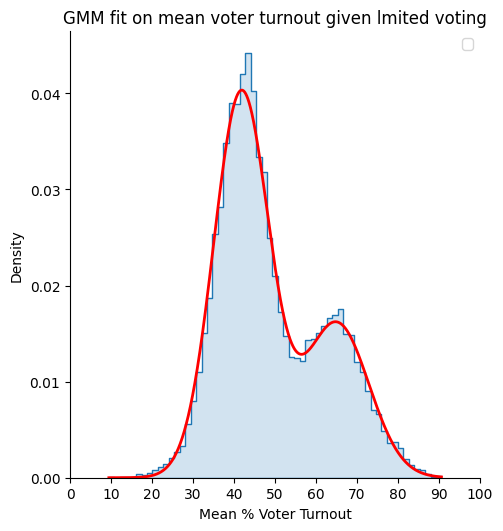

In [18]:
sns.displot(lim_data, stat='density', alpha=.2, element='step', legend=False)
xs = np.arange(lim_data.min(), lim_data.max(), .01)
pdf = np.zeros_like(xs)

for m, s, w, c in zip(gmm.means_, gmm.covariances_, gmm.weights_, ('red', 'green')):
    pdf += w * norm.pdf(xs, loc=m[0], scale=np.sqrt(s[0]))

plt.plot(xs, pdf, c='red', linewidth=2)
# plt.plot(xs, w * norm.pdf(xs, loc=m[0], scale=np.sqrt(s[0])), c=c, linewidth=2)
plt.legend("")
plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Mean % Voter Turnout')
plt.title('GMM fit on mean voter turnout given lmited voting')
plt.savefig('gmm_fit.pdf', bbox_inches='tight')
plt.show()

In [19]:
y = mean_data['voter_turnout']
X = mean_data.drop(['group', 'voter_turnout', 'election_type'], axis=1)
X['intercept'] = 1
groups = mean_data['group']

In [20]:
model = MixedLM(y, X, groups).fit()

In [21]:
print(model.summary())

                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     voter_turnout
No. Observations:     42000       Method:                 REML         
No. Groups:           3           Scale:                  79.3602      
Min. group size:      7435        Log-Likelihood:         -151475.8180 
Max. group size:      18000       Converged:              Yes          
Mean group size:      14000.0                                          
-----------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
winning_candidates          -1.574    0.024 -64.764 0.000 -1.621 -1.526
allowed_votes_per_election   1.221    0.035  34.581 0.000  1.152  1.290
number_candidates           -1.008    0.024 -41.479 0.000 -1.056 -0.961
number_voters               -0.026    0.001 -20.375 0.000 -0.029 -0.024
dimension

In [22]:
model.random_effects

{0: Group Var   -4.484668
 dtype: float64,
 1: Group Var    15.109641
 dtype: float64,
 2: Group Var   -10.624974
 dtype: float64}

In [23]:
preds = model.predict(X)

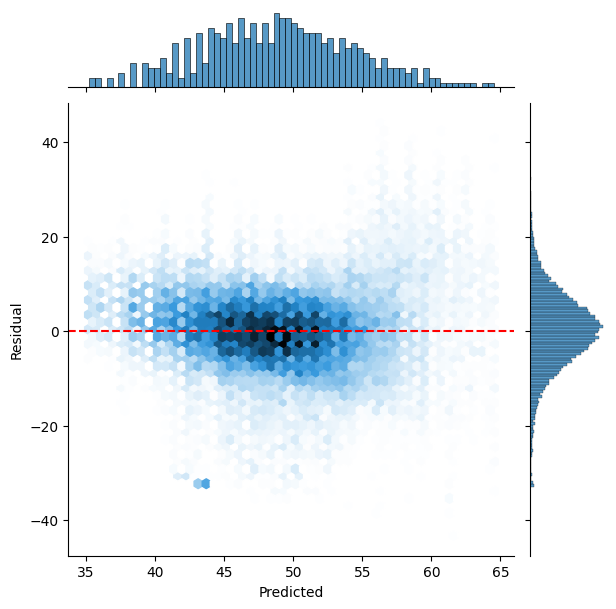

In [24]:
sns.jointplot(x=preds, y=model.resid, kind='hex')
plt.axhline(0, ls='--', c='red')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()